# 1 DEFINE the problem
* Use factors to predict whether passengers would survive on Titanic
* factors include: Cabin, Ticket, Fare, Sibsp, Parch, Embarked
* use the accuracy rate of cross validation to choose the best model
* then apply the model to the test data and submit it to kaggle to get the model accuracy for the test data

In [1]:
import sys
sys.path.insert(0, './modules')
from helpers import read_in_dataset

In [2]:
import inspect
print(inspect.getsource(read_in_dataset))

def read_in_dataset(fname, verbose = False):
    data = pd.read_csv(fname)
    if verbose:
        print('\n{0:*^80}'.format('Reading in the {0} dataset'.format(fname)))
        print('\nit has {0} rows and {1} columns'.format(*data.shape))
        print('\n{0:*^80}'.format('it has the following columns\n'))
        print(data.columns)
        print('\n{0:*^80}\n'.format('the first 5 rows looks like this'))
        print(data.head())
    return data



# 2 DISCOVER
## 2.1 study the datasets

In [53]:
train = read_in_dataset('data/train.csv', verbose = True)
test = read_in_dataset('data/test.csv',verbose = True)


*********************Reading in the data/train.csv dataset**********************

it has 891 rows and 12 columns

*************************it has the following columns
**************************
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

************************the first 5 rows looks like this************************

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
#inspired by Ken Jee
#understand the shape of the data .info(), #.describe(), missing value
#(Histogram, box plots, etc)
#value count for categoricals
#Missing data, to remove or compute
#correlation between the variables
#Explore interesting themes
    #Wealthy, Cabin location, Age, TotalSpent
#Feature Engineering
#preprocess
#Model Baseline
#Model comparison with CV

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
train_test     891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [54]:
#convert some variables to string, Pclass, PassengerId
from helpers import convert_col_to_str
train = convert_col_to_str(train,'Pclass')
train = convert_col_to_str(train,'PassengerId')

In [55]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891.000000,891,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,891,NaN,3,891,2,NaN,NaN,NaN,681,NaN,147,3
top,194,NaN,3,"Hart, Miss. Eva Miriam",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,1,NaN,491,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,NaN,0.383838,NaN,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,NaN,0.486592,NaN,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,NaN,0.000000,NaN,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,NaN,1.000000,NaN,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [14]:
#missing values in train
train_null = train.isnull().sum().sort_values(ascending=False)
train_null

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [16]:
#missing values in test
null_test = test.isnull().sum().sort_values(ascending=False)
null_test

Cabin          327
Age             86
Fare             1
Embarked         0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

## 2.2 plot the distribution of variables

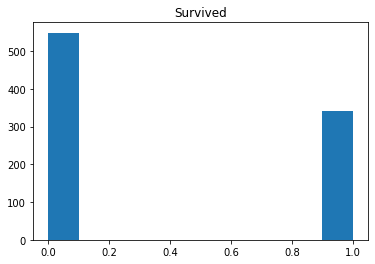

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


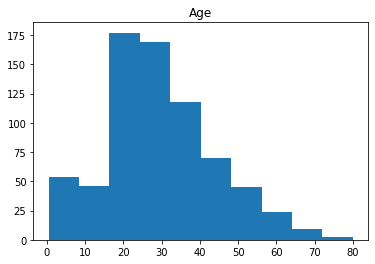

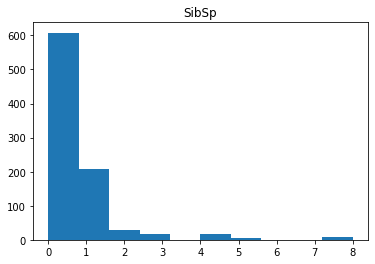

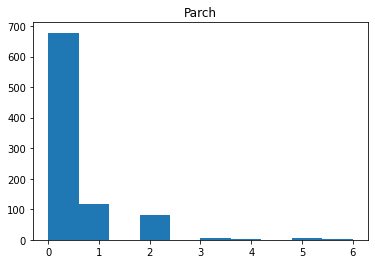

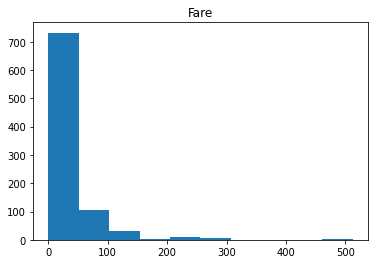

In [56]:
#select the numeric columns and plot histograms
df_num = train.select_dtypes(include = np.number)

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()
#Observation: age is pretty much normally distributed, the rest of the variables need normalization

          Survived       Age     SibSp     Parch      Fare
Survived  1.000000 -0.077221 -0.035322  0.081629  0.257307
Age      -0.077221  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307  0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

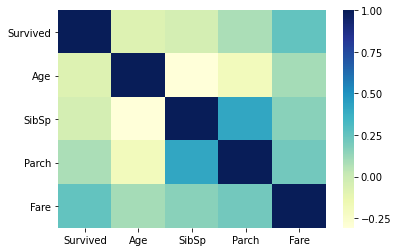

In [64]:
#plot the correlation of the numeric variables
print(df_num.corr())

sns.heatmap(df_num.corr(),cmap="YlGnBu")

#observation: Parch (number of parents/children aboard) is positively correlated with SibSp(number of sibling/spouse aboard)
#age is negatiavelly correated with SibSp (number of siblings)

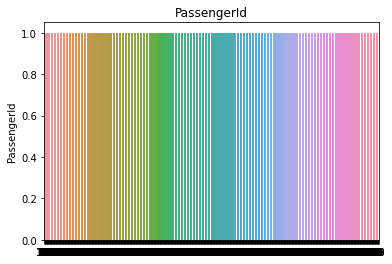

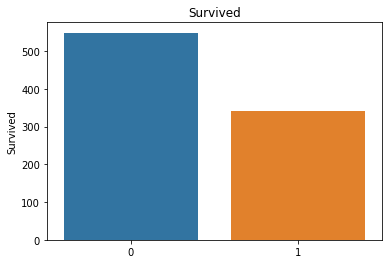

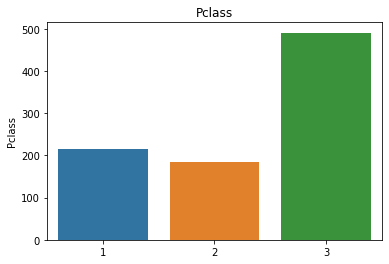

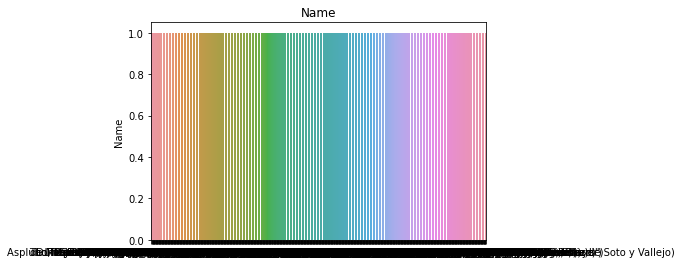

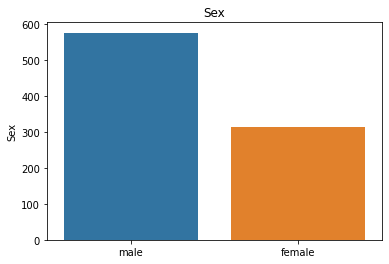

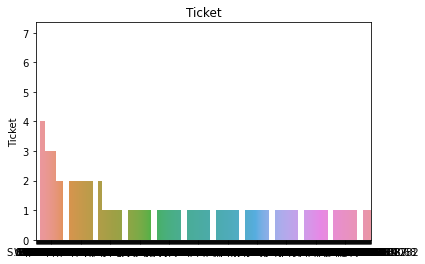

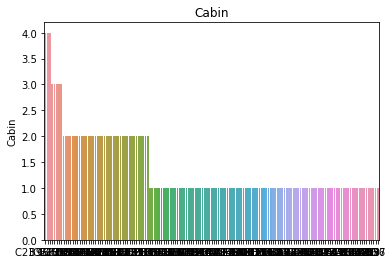

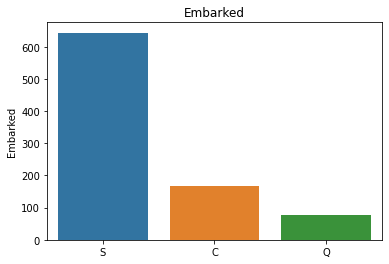

In [20]:
#barplot for all caregorical variables
df_cat = train.select_dtypes(include = 'object')
#categorical variables
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index, df_cat[i].value_counts()).set_title(i)
    plt.show()
#observations:    
#more male than female
#ticket number doesn't tell much inforamtion
#cabin number needs some more work to provide information
#more people embared from S than from C and Q
#more people died than survived
#more people are in the 3rd class cabin

In [61]:
#compare survival rate across all the numeric variables (Age, SibSp, Parch, and Fare)
pd.pivot_table(train, index = 'Survived', values = list(df_num.columns))
#observation, higher Faire has a higher survival rate
#high Parch has a higher survival rate
#lower SibSp and lower age has a higher survival rate


,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [71]:
#relate the categorical variables to Survival
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Name', aggfunc = 'count'))
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Name', aggfunc = 'count'))
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Name', aggfunc = 'count'))
#Survivied female > male
#Survivied Pclass 1 > 2 > 3
#Survivied Embarked C > O > S

Sex       female  male
Survived              
0             81   468
1            233   109
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


## 2.3 Experimenting with feature engineering

In [85]:
#Feature Engineering
#Simplify Cabin
#Tickets
#Person's Title

#Simplify Cabin by the number of cabins, NaN is 0
train['cabin_total'] = train.Cabin.apply(lambda x:0 if pd.isna(x) else len(x.split(' ')))
train['cabin_total'].value_counts().sort_index()

0    687
1    180
2     16
3      6
4      2
Name: cabin_total, dtype: int64

In [113]:
#The relation of cabin_total and survived
pd.pivot_table(train, index = 'Survived', columns = 'cabin_total', values = 'Name', aggfunc = 'count')
#people with 1, 2, 4 cabins have a higher survival propertion than nonsurvive


cabin_total,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [86]:
#some people are assigned to more than one cabine
train['cabin_firstletter'] = train.Cabin.apply(lambda x:str(x)[0])
train['cabin_firstletter'].value_counts().sort_index()
#n is for the missing values, but it can be used as a feature

A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
n    687
Name: cabin_firstletter, dtype: int64

In [112]:
#the relationship of cabin_firstletter and Survived
pd.pivot_table(train, index = 'Survived', columns = 'cabin_firstletter', values = 'Name', aggfunc = 'count')
#More people in the following categories survivied: B, D, E, F

cabin_firstletter,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [87]:
#simplify Ticket by the first word of the ticket, if it is a number replace it with None, otherwise use the first word
train['ticket_firstword'] = train.Ticket.apply(lambda x: 'None' if x.split(' ')[0].isdigit() else x.split(' ')[0])
train['ticket_firstword'].value_counts().sort_index()
#too many categories

A./5.           2
A.5.            2
A/4             3
A/4.            3
A/5            10
A/5.            7
A/S             1
A4.             1
C               5
C.A.           27
C.A./SOTON      1
CA              6
CA.             8
F.C.            1
F.C.C.          5
Fa              1
LINE            4
None          661
P/PP            2
PC             60
PP              3
S.C./A.4.       1
S.C./PARIS      2
S.O./P.P.       3
S.O.C.          5
S.O.P.          1
S.P.            1
S.W./PP         1
SC              1
SC/AH           3
SC/PARIS        5
SC/Paris        4
SCO/W           1
SO/C            1
SOTON/O.Q.      8
SOTON/O2        2
SOTON/OQ        7
STON/O         12
STON/O2.        6
SW/PP           1
W./C.           9
W.E.P.          1
W/C             1
WE/P            2
Name: ticket_firstword, dtype: int64

In [88]:
#simplify Ticket by the first letter of the ticket, if it is a number replace it with None, otherwise use the first word
train['ticket_firstletter'] = train.Ticket.apply(lambda x: 'None' if str(x)[0].isdigit() else str(x)[0])
train['ticket_firstletter'].value_counts().sort_index()

A        29
C        47
F         7
L         4
None    661
P        65
S        65
W        13
Name: ticket_firstletter, dtype: int64

In [122]:
#relation between ticket_firstletter and Survival
pd.pivot_table(train, index = 'Survived', columns = 'ticket_firstletter', values = 'Name', aggfunc = 'count')
#More survival with the following ticket_firstletter: F, P
#Very little survival with the following ticket_firstletter: A, W
#moderatte survival rate with the following ticket_firstletter: C, None

ticket_firstletter,A,C,F,L,None,P,S,W
Survived,,,,,,,,
0,27,31,3,3,407,23,44,11
1,2,16,4,1,254,42,21,2


In [123]:
train.Name.head(50)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [89]:
#strip out the title from the varialbe Name
train['name_title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train['name_title'].value_counts().sort_index()

Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
Name: name_title, dtype: int64

In [128]:
#name_title in relation to survival
pd.pivot_table(train, index = 'Survived', columns = 'name_title', values = 'Name', aggfunc = 'count')
#Survivied > non-Survived: Lady, Master, Miss, Mlle, Mme, Mrs, Ms, Sir, the Countess
#non-Survived > Survived: Capt, Don, Dr, Jonkheer, Mr, Rev,
#Survived = non-Survived: Col, Major



name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


In [90]:
#group together Capt, Don, Jonkheer
#because they only have 1 incidents and all belong to the nonsurvival category
#group goether Lady, Mlle, Mme, the Countess, Ms, Sir
#because they only have a couple incidents and all belong to the survival category
train['name_title_adv'] = train.name_title.apply(lambda x: 'title_survive' if x in 
                                                 ['Lady','Mlle','Mme', 'the Countess','Ms','Sir'] else 
                                                 'title_nonsurvive' if x in 
                                                 ['Capt','Don','Jonkheer'] else x)
train['name_title_adv'].value_counts().sort_index()

Col                   2
Dr                    7
Major                 2
Master               40
Miss                182
Mr                  517
Mrs                 125
Rev                   6
title_nonsurvive      3
title_survive         7
Name: name_title_adv, dtype: int64

In [137]:
pd.pivot_table(train, index = 'Survived', columns = 'name_title_adv', values = 'Name', aggfunc = 'count')


name_title_adv,Col,Dr,Major,Master,Miss,Mr,Mrs,Rev,title_nonsurvive,title_survive
Survived,,,,,,,,,,
0,1.0,4.0,1.0,17.0,55.0,436.0,26.0,6.0,3.0,NaN
1,1.0,3.0,1.0,23.0,127.0,81.0,99.0,NaN,NaN,7.0


## 2.4 plot potential features in relation to survival

In [34]:
#plot the survival rate in relation to the combination of other variables

#Survival ~ Sex * Age
male = train[train['Sex']=='male']
female = train[train['Sex']=='female']
male_survived = male[male['Survived']=='1'].Age.dropna()
male_nosurvive = male[male['Survived']=='0'].Age.dropna()
female_survived = female[female['Survived']=='1'].Age.dropna()
female_nosurvive = female[female['Survived']=='0'].Age.dropna()

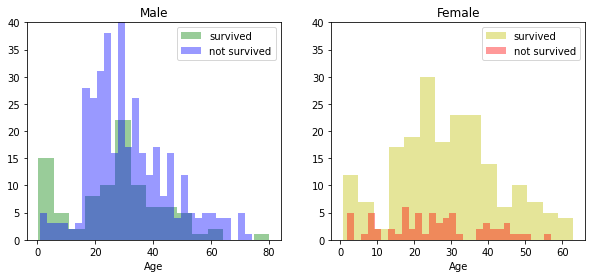

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax = sns.distplot(male_survived, bins=15, label = 'survived', ax = axes[0], kde = False, color = 'g')
ax = sns.distplot(male_nosurvive, bins=30, label = 'not survived', ax = axes[0], kde = False, color = 'b')
ax.legend()
ax.set_title('Male')
ax.set_ylim(0,40)
ax = sns.distplot(female_survived, bins=15, label = 'survived', ax = axes[1], kde = False, color = 'y')
ax = sns.distplot(female_nosurvive, bins=30, label = 'not survived', ax = axes[1], kde = False, color = 'r')
ax.legend()
ax.set_title('Female')
ax.set_ylim(0,40)
plt.show()
#observation: male 20-40 yr many not survived
#female has a large survival rate across all ages


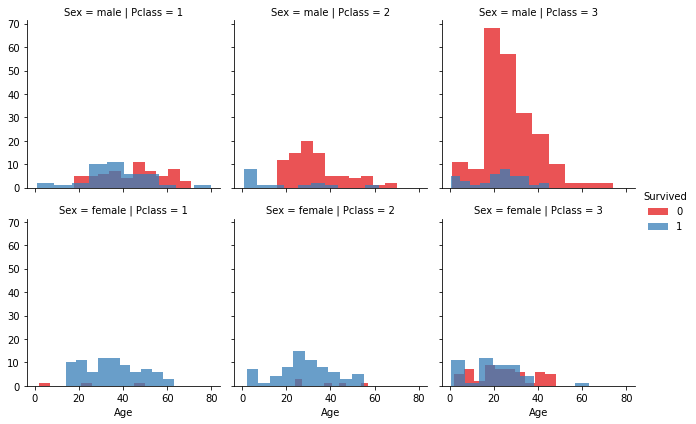

In [45]:
#Survival ~ Age * Sex * Pclass
plot2 = sns.FacetGrid(train, row = 'Sex', col = 'Pclass', hue = 'Survived', palette = "Set1")
plot2.map(plt.hist, 'Age', alpha = .75)
plot2.add_legend()
#observation, male from age 20-40 in Pclass 2 and 3 mostly did not survive

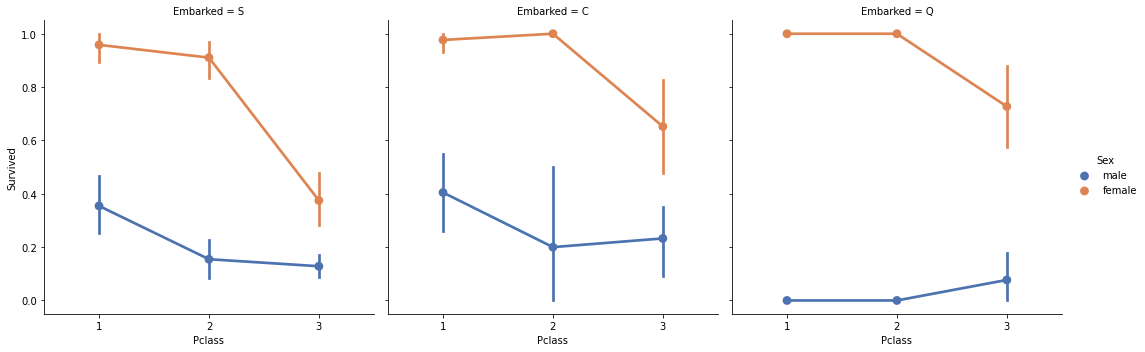

In [80]:
#Survival ~ Embarked * Pclass * Sex
#Observations: Pclass 3 has a much lower survival rate than Pclass 1 and 2 across Sex and Embarked
#Male when Embarked from Q has a particular lower survival rate than Embarked S and C

sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', col = 'Embarked', data = train, palette = 'deep', kind = 'point')

<AxesSubplot:xlabel='Age', ylabel='Fare'>

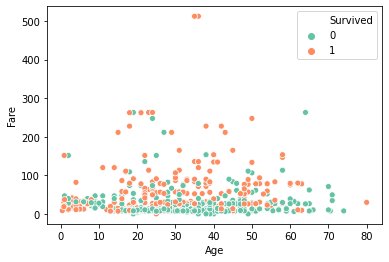

In [104]:
#Survival ~ Age + Fare
#observation: Higher fare has a higher survival rate across most of the age spectrum. 
#Younger age 0-10 has a higher survival rate
#older age 60 + has a lower survival rate

sns.scatterplot(x="Age", y="Fare",
                     hue="Survived", palette="Set2",
                     sizes=(20, 200), hue_norm=(0, 7),
                     legend="full", data = train)


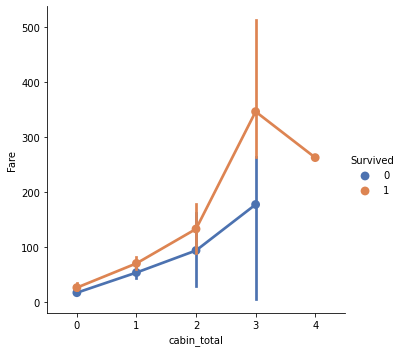

In [93]:
#Survival: fare + cabin_firstletter + cabin_totaltlink
sns.catplot(x = 'cabin_total', y = 'Fare', hue = 'Survived', 
            data = train, palette = 'deep', kind = 'point')

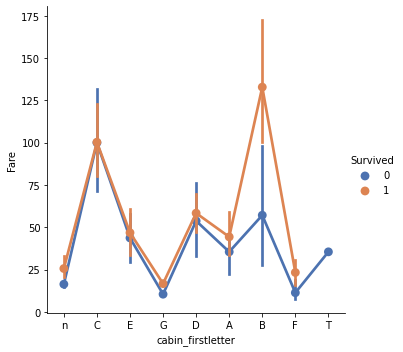

In [94]:
#Survival: fare + cabin_firstletter + cabin_totaltlink
sns.catplot(x = 'cabin_firstletter', y = 'Fare', hue = 'Survived', 
            data = train, palette = 'deep', kind = 'point')

<AxesSubplot:xlabel='cabin_firstletter', ylabel='Fare'>

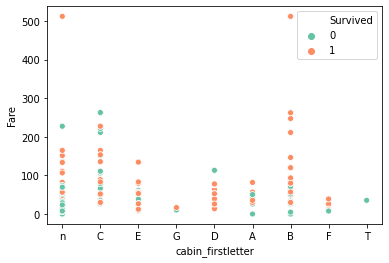

In [96]:
sns.scatterplot(x="cabin_firstletter", y="Fare",
                     hue="Survived", palette="Set2",
                     sizes=(20, 200), hue_norm=(0, 7),
                     legend="full", data = train)

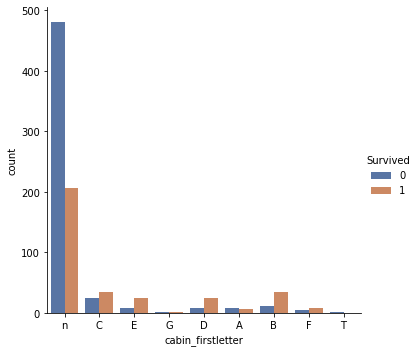

In [99]:
sns.catplot(x = 'cabin_firstletter', hue = 'Survived', 
            data = train, palette = 'deep', kind = 'count')

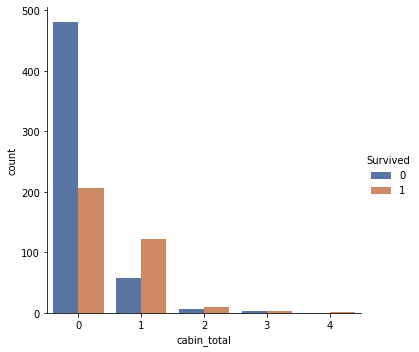

In [124]:
sns.catplot(x = 'cabin_total', hue = 'Survived', 
            data = train, palette = 'deep', kind = 'count')

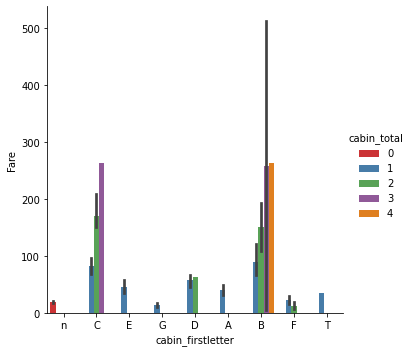

In [125]:
#Survival
#numerical: Age, Parch, Sibsp, Fare
#categorial: Pclass, Sex, Embarked, cabin_total, cabin_firstletter, ticket_firstletter, name_title_adv

#study the newly engineered feature
#how is cabin_total relate to fare and cabin_firstletter?
sns.catplot(x="cabin_firstletter", y="Fare",
                     hue="cabin_total", palette="Set1",data = train, kind = "bar")

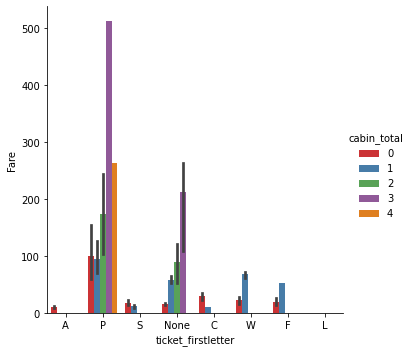

In [126]:
sns.catplot(x="ticket_firstletter", y="Fare",
                     hue="cabin_total", palette="Set1",data = train, kind = "bar")

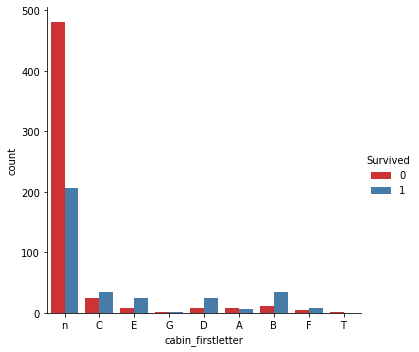

In [129]:
sns.catplot(x="cabin_firstletter",
                     hue="Survived", palette="Set1",data = train, kind = "count")

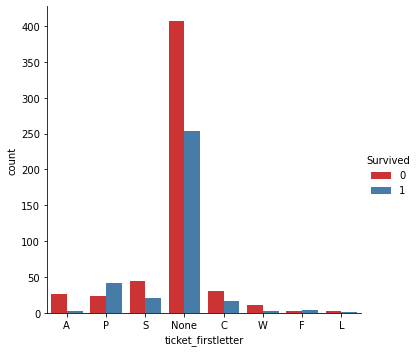

In [130]:
sns.catplot(x="ticket_firstletter",
                     hue="Survived", palette="Set1",data = train, kind = "count")

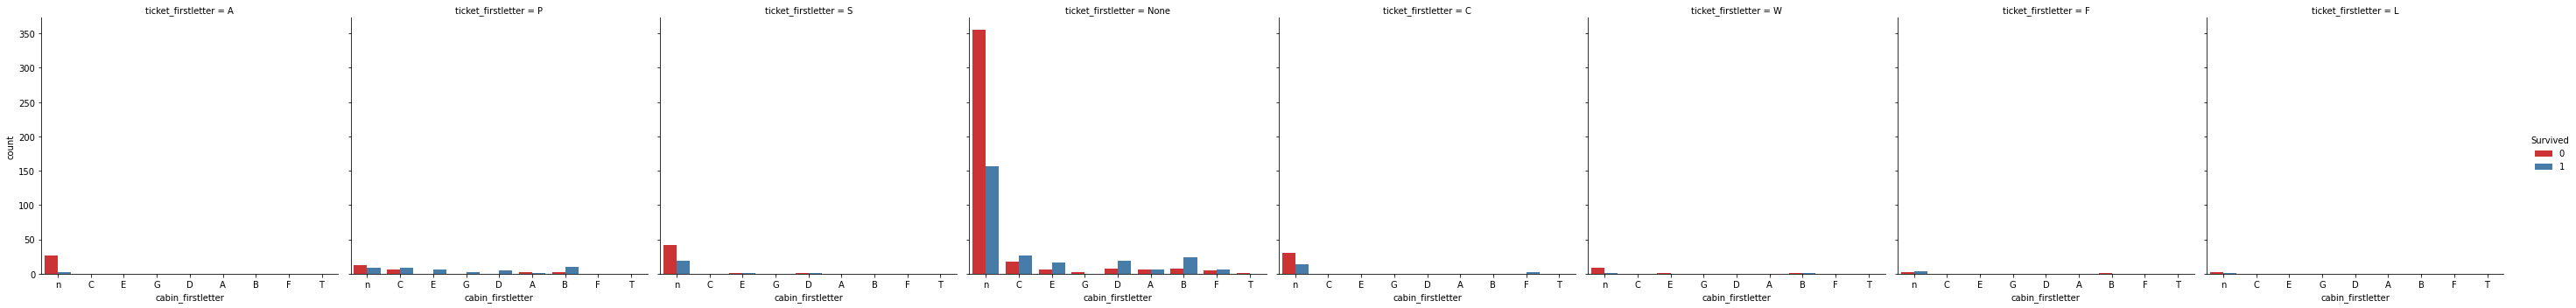

In [133]:
#ticket first letter may not carry much information
#because the in the majority of ticket_firstletter, non-survive > survived, except in P
sns.catplot(x="cabin_firstletter", col = 'ticket_firstletter',
                     hue="Survived", palette="Set1",data = train, kind = "count")

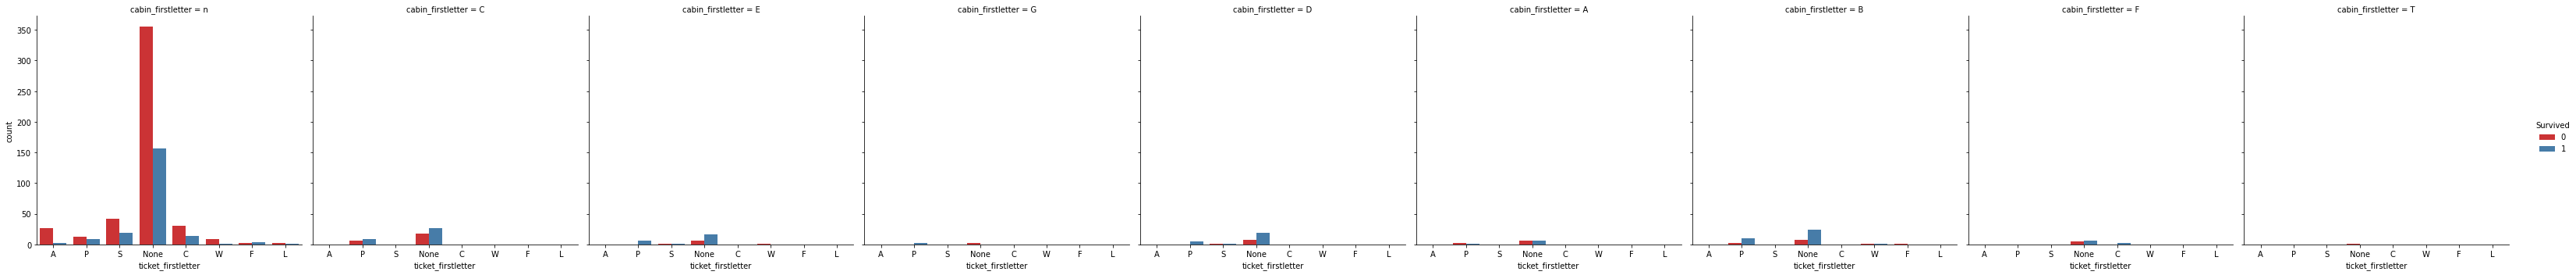

In [134]:
sns.catplot(x="ticket_firstletter", col = 'cabin_firstletter',
                     hue="Survived", palette="Set1",data = train, kind = "count")

<Figure size 3600x432 with 0 Axes>

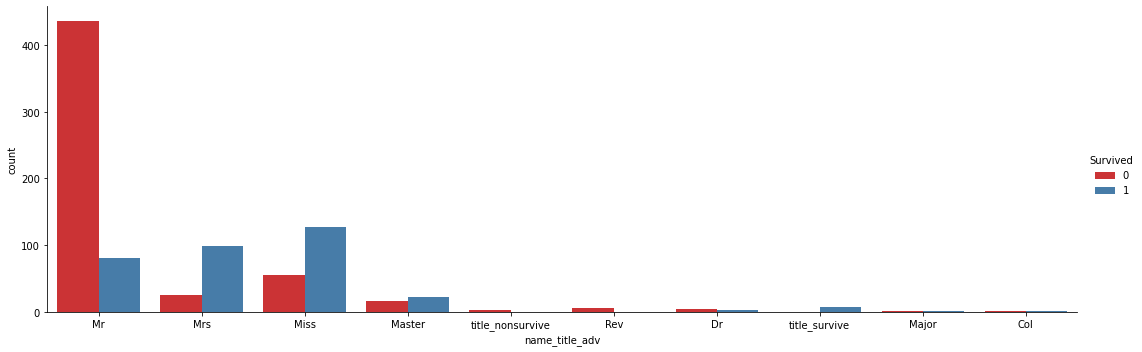

In [144]:
plt.figure(figsize=(50, 6))
sns.catplot(x="name_title_adv",
                     hue="Survived", palette="Set1",data = train, kind = "count", height = 5, aspect = 3)

## 2.5 conclusion: 
* based on EDA, the following variables should be included as features:
* Pclass, name_title_adv, Sex, Age, Sibsp, Parch, Fare, Embarked, cabin_total, cabin_firstletter, ticket_firstletter